In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
from torchvision import transforms
from PIL import Image

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from skorch import NeuralNet
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from skorch import NeuralNetRegressor

import pandas as pd

In [2]:
# data = pd.read_csv('data/UCI-Data/spambase.data')
# spam_data = pd.DataFrame.to_numpy(data)


In [3]:
# spam_data.shape

(4600, 58)

## Variables

*Train Vars*
- `spam_matrices` : Training mats
- `spam_singular` : Training singular
- `spam_ranks` : Training ranks

*Test Vars*
- `spam_matrices_test` : Test mats
- `spam_singular_test` : Test singular
- `spam_ranks_test` : Test ranks

In [3]:
# search for existing data
try:
    print('Finding Existing Data')
    spam_matrices = np.load('data/Matrix_gens/UCI_data/spam_data_mat.npy')
    spam_singular = np.load('data/Matrix_gens/UCI_data/spam_data_singular.npy')
    spam_ranks = np.load('data/Matrix_gens/UCI_data/spam_data_ranks.npy')

    spam_matrices_test = np.load('data/Matrix_gens/UCI_data/spam_data_test.npy')
    spam_singular_test = np.load('data/Matrix_gens/UCI_data/spam_data_singular_test.npy')
    spam_ranks_test = np.load('data/Matrix_gens/UCI_data/spam_data_ranks_test.npy')
    print('Data Found')
except:
    # placing values of image into matrices

    # arrays only used for integration  
    print('Data not found... Creating NP Arrays')

    arr_temp = []
    arr_sing_temp = []
    arr_rank_temp = []

    data = pd.read_csv('data/spambase.data')
    spam_data = pd.DataFrame.to_numpy(data)

    # w_data acts as windowed data
    w_data = np.lib.stride_tricks.sliding_window_view(spam_data, (32,32))
    w_data = np.reshape(w_data, (w_data.shape[0] * w_data.shape[1], 32, 32))


    for mat in w_data:
            # svd and rank
            U, sigma, V = np.linalg.svd(mat) # computes the SVD
            rank = np.linalg.matrix_rank(mat, tol=0.001)

            arr_temp.append(mat)
            arr_sing_temp.append(sigma)
            arr_rank_temp.append(rank)

    spam_matrices = np.array(arr_temp)
    spam_singular = np.array(arr_sing_temp)
    spam_ranks = np.array(arr_rank_temp)

    # split data to train/test
    spam_matrices_train, spam_matrices_test, spam_singular_train, spam_singular_test, spam_ranks_train, spam_ranks_test = train_test_split(spam_matrices, spam_singular, spam_ranks, test_size=0.15, random_state=42)

    np.save('data/Matrix_gens/UCI_data/spam_data_mat', spam_matrices_train)
    np.save('data/Matrix_gens/UCI_data/spam_data_singular.npy', spam_singular_train)
    np.save('data/Matrix_gens/UCI_data/spam_data_ranks.npy', spam_ranks_train)

    np.save('data/Matrix_gens/UCI_data/spam_data_test.npy',spam_matrices_test)
    np.save('data/Matrix_gens/UCI_data/spam_data_singular_test.npy',spam_singular_test)
    np.save('data/Matrix_gens/UCI_data/spam_data_ranks_test.npy', spam_ranks_test)
    
        

Finding Existing Data
Data not found... Creating NP Arrays


FileNotFoundError: [Errno 2] No such file or directory: 'data/UCI-Data/spambase.data'

In [5]:
spam_matrices.shape

(104858, 32, 32)

In [6]:
# MODEL
class RegressorModule(nn.Module):
    def __init__(self, num_units=5000, nonlin=F.relu): # why this param list
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(1024, num_units)
        #self.dropout0 = nn.Dropout(0.7)
        self.dense1 = nn.Linear(num_units,750)
        #self.dropout = nn.Dropout(0.7)
        self.dense2 = nn.Linear(750, 300)
        #self.dropout2 = nn.Dropout(0.7)
        self.dense3 = nn.Linear(300, 100)
        self.output = nn.Linear(100, 32)

    def forward (self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        #X = self.dropout0(X)
        X = self.nonlin(self.dense1(X))
        #X = self.dropout(X)
        X = self.nonlin(self.dense2(X))
        #X = self.dropout2(X)
        X = self.nonlin(self.dense3(X))
        X = self.nonlin(self.output(X))
        #X = F.softmax(self.output(X), dim=-1)
        return X

net = NeuralNetRegressor(
    RegressorModule, # pytorch module
    #train_split=None,
    criterion = nn.L1Loss, 
    max_epochs=512,
    lr=0.0001,
    device='cuda',
)

In [7]:
flattened = np.reshape(spam_matrices, (104858, 1024))
flattened = flattened.astype(np.float32)
spam_singular = spam_singular.astype(np.float32)

In [8]:
net.fit(flattened, spam_singular)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.8460       10.7868  3.3014
      2       10.8268       10.7696  2.5871
      3       10.8085       10.7506  2.8632
      4       10.7890       10.7308  2.5731
      5       10.7683       10.7092  2.4759
      6       10.7446       10.6832  2.4622
      7       10.7147       10.6490  2.5423
      8       10.6739       10.6004  2.4517
      9       10.6129       10.5242  2.4893
     10       10.5117       10.3920  2.5340
     11       10.3342       10.1606  2.5616
     12       10.0213        9.7475  2.5375
     13        9.4767        9.0383  2.5292
     14        8.4507        7.5486  2.5343
     15        5.3103        2.5334  2.5385
     16        2.4310        2.3898  2.5316
     17        2.3534        2.3249  2.5382
     18        2.2904        2.2668  2.5610
     19        2.2361        2.2150  2.5566
     20        2.1894        2.1744  2.5530
     21        2.1510        2.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (dense0): Linear(in_features=1024, out_features=5000, bias=True)
    (dense1): Linear(in_features=5000, out_features=750, bias=True)
    (dense2): Linear(in_features=750, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=32, bias=True)
  ),
)

In [89]:
net.save_params(f_params='models/spam_trained_l1.pkl')

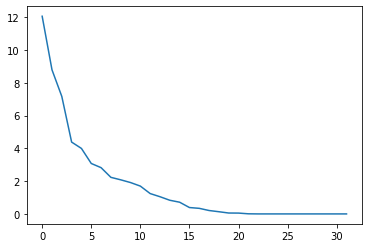

In [10]:
plt.plot(spam_singular[0])

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing

In [12]:
#testing = CifarDataset(test_image_matrices,test_)
testing = np.reshape(spam_matrices_test, (18505, 1024))
testing = testing.astype(np.float32)
y_pred = net.predict(testing)

In [13]:
spam_singular_test[0]
y_pred

array([[  16.330095 ,    8.347423 ,    5.341086 , ...,    0.       ,
           0.       ,    0.       ],
       [1337.1908   ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [  34.574856 ,   20.632122 ,   12.804782 , ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [  24.943441 ,   14.539649 ,    9.109832 , ...,    0.       ,
           0.       ,    0.       ],
       [  21.297293 ,   12.5428   ,    7.7629495, ...,    0.       ,
           0.       ,    0.       ],
       [  43.140057 ,   18.875685 ,   10.757499 , ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

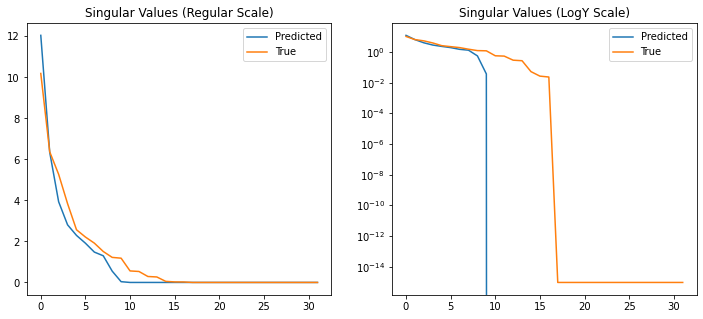

In [104]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
randint = np.random.randint(18505)
#x = np.sort(y_pred[randint][:])[::-1]
x = (y_pred[randint][:])
x = np.sort(x)[::-1]
axs[0].set_title('Singular Values (Regular Scale)')
axs[0].plot(x, label='Predicted')
axs[0].plot(spam_singular_test[randint][:], label='True')
axs[0].legend()

axs[1].set_title('Singular Values (LogY Scale)')
axs[1].semilogy(x, label='Predicted')
axs[1].semilogy(spam_singular_test[randint][:], label='True')
axs[1].legend()

In [15]:
MSE_loss = []
MAE_loss = []

for mat in range(len(testing)):
    MSE_loss.append(mean_squared_error(y_pred[mat][:], spam_singular_test[mat][:]))
    MAE_loss.append(mean_absolute_error(y_pred[mat][:], spam_singular_test[mat][:]))
MSE = np.array(MSE_loss)
MAE = np.array(MAE_loss)

print("NOTE: Singular value MAX values vary from ~16-20000")
print(f"Data Singulars Max: Pred - {np.max(y_pred)} | True - {np.max(spam_singular_test)} \nData Min: Pred - {np.min(y_pred)} | True - {np.min(spam_singular_test)}")
print(f"Data Singulars MED: Pred - {np.median(y_pred)} | True - {np.median(spam_singular_test)}")
print (f"MSE | Mean: {np.mean(MSE)} SD: {np.std(MSE)}")
print ('-----------------------')
print (f"MAE | Mean: {np.mean(MAE)} SD: {np.std(MAE)}")

NOTE: Singular value MAX values vary from ~16-20000
Data Singulars Max: Pred - 16478.373046875 | True - 16275.951034803653 
Data Min: Pred - 0.0 | True - 1.2154416038822565e-44
Data Singulars MED: Pred - 0.0 | True - 0.34028141795333555
MSE | Mean: 82.46791517976003 SD: 1025.0247727228223
-----------------------
MAE | Mean: 1.0057885028136582 SD: 2.1427148634667077


Notes:

- lots of variance in the singular value ranges
- mse loss still yields NaN values (l1 loss still works)
- prediction much better without dropout layers in neural model